# Refactor bus corridors

In [1]:
import dask.dataframe as dd
import dask_geopandas
import datetime as dt
import geopandas as gpd
import pandas as pd

import B1_bus_corridors as bus_corridors
from shared_utils import utils
from utilities import catalog_filepath

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
COMBINED_CLIPPED = catalog_filepath("combined_clipped_intersections")
gdf = gpd.read_parquet(COMBINED_CLIPPED)

<AxesSubplot:>

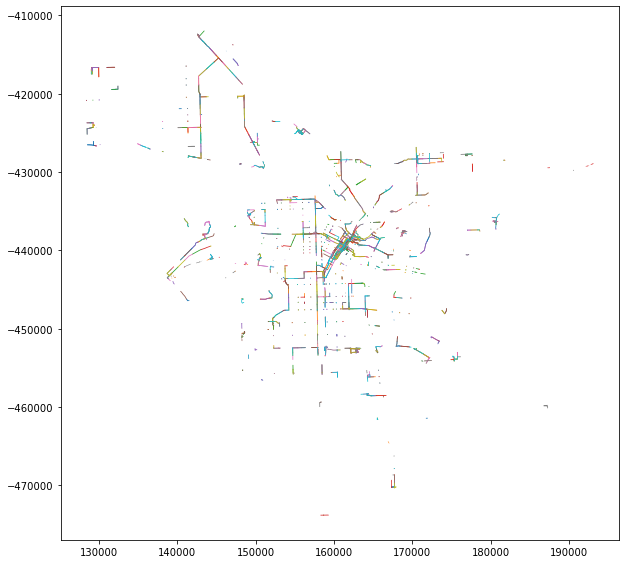

In [4]:
itp_id = 182

gdf[gdf.calitp_itp_id == itp_id].plot(column="hqta_segment_id", 
                                      figsize=(10, 10), cmap="tab10"
                                     )

In [ ]:
#https://stackoverflow.com/questions/71688126/groupby-map-partitions-in-dask
trips_by_stop_hour = stop_times.map_partitions(
    lambda df: df.groupby(["calitp_itp_id", "stop_id"], as_index=False)
        .agg({"trip_id": "count"}), meta={"calitp_itp_id": int,
                                          "stop_id": str,
                                          "trip_id": int
                                         }
)